In [21]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
import scipy
import skimage
import tensorflow as tf
from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [2]:
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = './dataset/notmnist' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
    """A hook to report the progress of a download. This is mostly intended for users with
    slow internet connections. Reports every 5% change in download progress.
    """
    global last_percent_reported
    percent = int(count * blockSize * 100 / totalSize)

    if last_percent_reported != percent:
        if percent % 5 == 0:
            sys.stdout.write("%s%%" % percent)
            sys.stdout.flush()
        else:
            sys.stdout.write(".")
            sys.stdout.flush()
      
        last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
    """Download a file if not present, and make sure it's the right size."""
    dest_filename = os.path.join(data_root, filename)
    if force or not os.path.exists(dest_filename):
        print('Attempting to download:', filename) 
        filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
        print('\nDownload Complete!')
    statinfo = os.stat(dest_filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', dest_filename)
    else:
        raise Exception('Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
    return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified ./dataset/notmnist/notMNIST_large.tar.gz
Found and verified ./dataset/notmnist/notMNIST_small.tar.gz


In [3]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
    root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
    if os.path.isdir(root) and not force:
        # You may override by setting force=True.
        print('%s already present - Skipping extraction of %s.' % (root, filename))
    else:
        print('Extracting data for %s. This may take a while. Please wait.' % root)
        tar = tarfile.open(filename)
        sys.stdout.flush()
        tar.extractall(data_root)
        tar.close()
    data_folders = [
        os.path.join(root, d) for d in sorted(os.listdir(root)) if os.path.isdir(os.path.join(root, d))]
    if len(data_folders) != num_classes:
        raise Exception('Expected %d folders, one per class. Found %d instead.' % (num_classes, len(data_folders)))
    print(data_folders)
    return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders  = maybe_extract(test_filename)

./dataset/notmnist/notMNIST_large already present - Skipping extraction of ./dataset/notmnist/notMNIST_large.tar.gz.
['./dataset/notmnist/notMNIST_large/A', './dataset/notmnist/notMNIST_large/B', './dataset/notmnist/notMNIST_large/C', './dataset/notmnist/notMNIST_large/D', './dataset/notmnist/notMNIST_large/E', './dataset/notmnist/notMNIST_large/F', './dataset/notmnist/notMNIST_large/G', './dataset/notmnist/notMNIST_large/H', './dataset/notmnist/notMNIST_large/I', './dataset/notmnist/notMNIST_large/J']
./dataset/notmnist/notMNIST_small already present - Skipping extraction of ./dataset/notmnist/notMNIST_small.tar.gz.
['./dataset/notmnist/notMNIST_small/A', './dataset/notmnist/notMNIST_small/B', './dataset/notmnist/notMNIST_small/C', './dataset/notmnist/notMNIST_small/D', './dataset/notmnist/notMNIST_small/E', './dataset/notmnist/notMNIST_small/F', './dataset/notmnist/notMNIST_small/G', './dataset/notmnist/notMNIST_small/H', './dataset/notmnist/notMNIST_small/I', './dataset/notmnist/not

In [4]:
import random

# Visualise a sample of each label
def display_images(filename, samples_per_label):
    print ('Displaying images in: ', filename)
    folder = os.path.join(data_root, filename)
    for label in sorted(os.listdir(folder)):
        if(label.endswith('.pickle') == False):
            print ('Label: ', label)
            label_folder = os.path.join(folder, label)
            dirs = os.listdir(label_folder)
            random.shuffle(dirs)
            for image in dirs[:samples_per_label]:
                display(Image(filename=os.path.join(label_folder, image), width=20.0, height=20.0))
            
display_images('notMNIST_large', 5)
display_images('notMNIST_small', 5)

Displaying images in:  notMNIST_large
Label:  A


Label:  B


Label:  C


Label:  D


Label:  E


Label:  F


Label:  G


Label:  H


Label:  I


Label:  J


Displaying images in:  notMNIST_small
Label:  A


Label:  B


Label:  C


Label:  D


Label:  E


Label:  F


Label:  G


Label:  H


Label:  I


Label:  J


In [8]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
    """Load the data for a single letter label."""
    image_files = os.listdir(folder)
    dataset = np.ndarray(shape=(len(image_files), image_size, image_size), dtype=np.float32)
    print(folder)
    num_images = 0
    for image in image_files:
        image_file = os.path.join(folder, image)
        try:
            image_data = (imageio.imread(image_file).astype(float) - pixel_depth / 2) / pixel_depth
            if image_data.shape != (image_size, image_size):
                raise Exception('Unexpected image shape: %s' % str(image_data.shape))
            dataset[num_images, :, :] = image_data
            num_images = num_images + 1
        except (IOError, ValueError) as e:
            print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
    dataset = dataset[0:num_images, :, :]
    if num_images < min_num_images:
        raise Exception('Many fewer images than expected: %d < %d' % (num_images, min_num_images))
    
    print('Full dataset tensor:', dataset.shape)
    print('Mean:', np.mean(dataset))
    print('Standard deviation:', np.std(dataset))
    return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
    dataset_names = []
    for folder in data_folders:
        set_filename = folder + '.pickle'
        dataset_names.append(set_filename)
        if os.path.exists(set_filename) and not force:
            # You may override by setting force=True.
            print('%s already present - Skipping pickling.' % set_filename)
        else:
            print('Pickling %s.' % set_filename)
            dataset = load_letter(folder, min_num_images_per_class)
            try:
                with open(set_filename, 'wb') as f:
                    pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
            except Exception as e:
                print('Unable to save data to', set_filename, ':', e)
  
    return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

./dataset/notmnist/notMNIST_large/A.pickle already present - Skipping pickling.
./dataset/notmnist/notMNIST_large/B.pickle already present - Skipping pickling.
./dataset/notmnist/notMNIST_large/C.pickle already present - Skipping pickling.
./dataset/notmnist/notMNIST_large/D.pickle already present - Skipping pickling.
./dataset/notmnist/notMNIST_large/E.pickle already present - Skipping pickling.
./dataset/notmnist/notMNIST_large/F.pickle already present - Skipping pickling.
./dataset/notmnist/notMNIST_large/G.pickle already present - Skipping pickling.
./dataset/notmnist/notMNIST_large/H.pickle already present - Skipping pickling.
./dataset/notmnist/notMNIST_large/I.pickle already present - Skipping pickling.
./dataset/notmnist/notMNIST_large/J.pickle already present - Skipping pickling.
Pickling ./dataset/notmnist/notMNIST_small/A.pickle.
./dataset/notmnist/notMNIST_small/A
Could not read: ./dataset/notmnist/notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png : Could no

Displaying pickles from train dataset


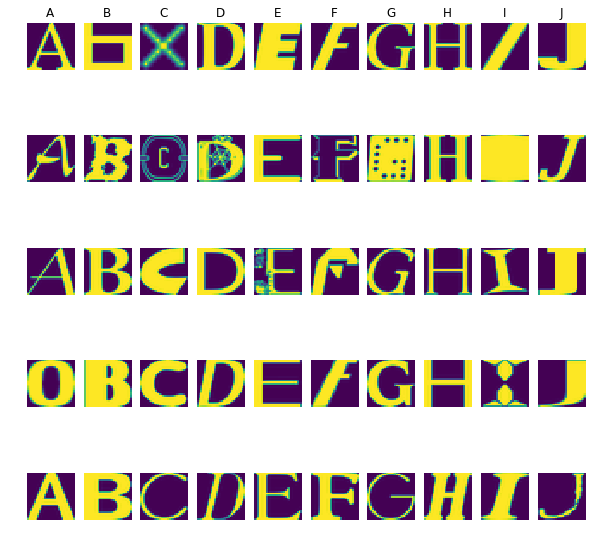

Displaying pickles from test dataset


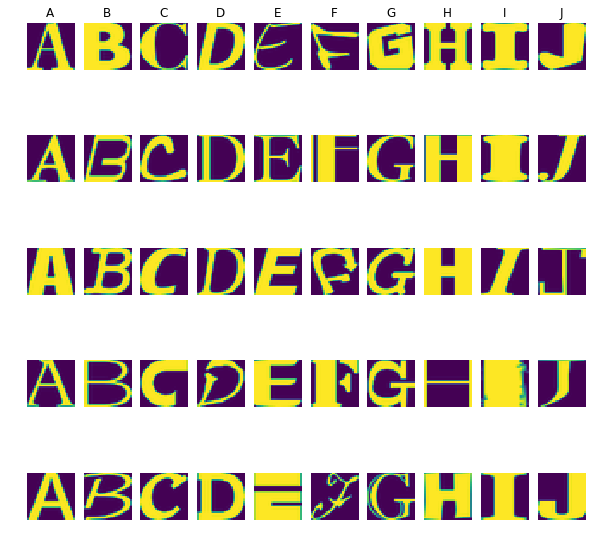

In [10]:
plt.rcParams['figure.figsize'] = (10.0, 10.0) # set default size of plots
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
num_labels = len(labels)

def display_pickle(dataset, samples_per_label):
    for y, label in enumerate(labels):
        pickles = pickle.load(open(dataset[y], 'rb'))
        idxs = np.random.choice(pickles.shape[0], samples_per_label, replace=False)
        for i, idx in enumerate(idxs):
            plt_idx = i * num_labels + y + 1
            plt.subplot(samples_per_label, num_labels, plt_idx)
            plt.imshow(pickles[idx, :, :])
            plt.axis('off')
            if i == 0:
                plt.title(label)
    plt.show()
    

print ('Displaying pickles from train dataset')
display_pickle(train_datasets, 5)
print ('Displaying pickles from test dataset')
display_pickle(test_datasets, 5)

In [11]:
# Verify if the data is balanced across classes
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
num_labels = len(labels)

def print_num_example(dataset):
    for y, label in enumerate(labels):
        pickles = pickle.load(open(dataset[y], 'rb'))
        print ('Label: %s --- num example: %d' % (label, pickles.shape[0]))

print ('Train Dataset')
print_num_example(train_datasets)
print ('Test Dataset')
print_num_example(test_datasets)

Train Dataset
Label: A --- num example: 52909
Label: B --- num example: 52911
Label: C --- num example: 52912
Label: D --- num example: 52911
Label: E --- num example: 52912
Label: F --- num example: 52912
Label: G --- num example: 52912
Label: H --- num example: 52912
Label: I --- num example: 52912
Label: J --- num example: 52911
Test Dataset
Label: A --- num example: 1872
Label: B --- num example: 1873
Label: C --- num example: 1873
Label: D --- num example: 1873
Label: E --- num example: 1873
Label: F --- num example: 1872
Label: G --- num example: 1872
Label: H --- num example: 1872
Label: I --- num example: 1872
Label: J --- num example: 1872


/Users/brunonishimoto/anaconda3/envs/udacity/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/brunonishimoto/anaconda3/envs/udacity/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


[ 9  9  9 10 10]


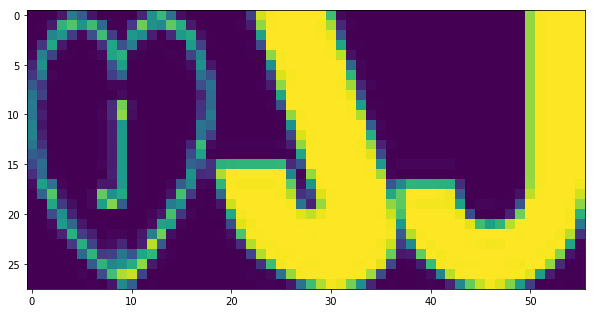

In [12]:
img_size = image_size
new_size = (28, 56)

def make_arrays(nb_rows, size):
    if nb_rows:
        dataset = np.ndarray((nb_rows, size[0], size[1]), dtype=np.float32)
        labels = np.ndarray((nb_rows, 5), dtype=np.int32)
    else:
        dataset, labels = None, None
    return dataset, labels

def merge_datasets(pickle_files, dataset_size):
    dataset, labels = make_arrays(dataset_size, new_size)
    pickles = []
    for i in range(10):
        pickles.append(pickle.load(open(pickle_files[i], 'rb')))

    for i in range(dataset_size):
        # Generate a random label with max length 5 chars
        data_length  = np.random.choice(5, 1)[0] + 1
        random_chars = np.random.choice(10, data_length)
        data_label   = np.append(random_chars, np.full(5 - data_length, 10, dtype=int))
        
        chars = []
        
        for char in random_chars:
            index = np.random.choice(len(pickles[char]), 1)
            chars.append(np.reshape(pickles[char][index, :, :], (img_size, img_size)))

        image = np.ndarray((img_size, data_length * img_size))
        
        for idx, char in enumerate(chars):
            image[:, img_size*idx:img_size*(idx+1)] = char

        image = skimage.transform.resize(image, new_size)
        dataset[i] = image
        labels[i]  = data_label
    return dataset, labels

train_dataset, train_labels = merge_datasets(train_datasets, 200000)
valid_dataset, valid_labels = merge_datasets(train_datasets, 20000)
test_dataset, test_labels   = merge_datasets(test_datasets, 20000)

print(train_labels[80])
plt.imshow(train_dataset[80])
plt.show()

In [13]:
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation,:,:]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels

train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

Displaying training images
[[ 2  6  8 10 10]
 [ 2  1 10 10 10]
 [ 9 10 10 10 10]]


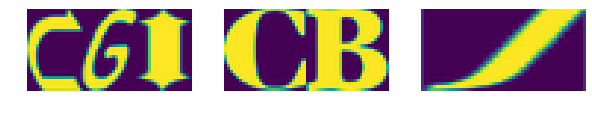

Displaying test images
[[ 9  4 10 10 10]
 [ 6  9  7  3 10]
 [ 9  1  2  5  1]]


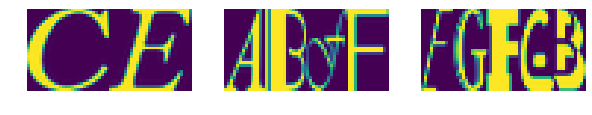

Displaying validation images
[[ 2 10 10 10 10]
 [ 2  4  3  3  8]
 [ 6 10 10 10 10]]


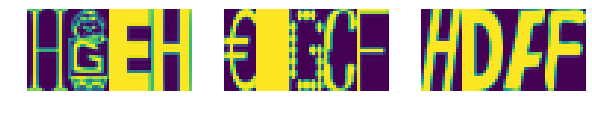

In [14]:
def display_dataset(dataset, samples_per_label):
    idxs = np.random.choice(dataset.shape[0], samples_per_label, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i + 1
        plt.subplot(1, samples_per_label, plt_idx)
        plt.imshow(dataset[idx])
        plt.axis('off')
    print(train_labels[idxs])
    plt.show()
    
print ('Displaying training images')
display_dataset(train_dataset, 3)
print ('Displaying test images')
display_dataset(test_dataset, 3)
print ('Displaying validation images')
display_dataset(valid_dataset, 3)

In [15]:
new_size = (28, 56)
num_labels = 11
num_channels = 1 # grayscale

import numpy as np

def reformat(dataset, labels):
    dataset = dataset.reshape((-1, new_size[0], new_size[1], num_channels)).astype(np.float32)
    labels = np.eye(11)[labels]
    
    return dataset, labels

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)

print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 56, 1) (200000, 5, 11)
Validation set (20000, 28, 56, 1) (20000, 5, 11)
Test set (20000, 28, 56, 1) (20000, 5, 11)


In [19]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0])

## Network

In [26]:
batch_size = 32
patch_size = 5
depth = 16
num_hidden = 64
image_size = (28, 56)

graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size[0], image_size[1], num_channels))
    tf_train_labels  = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset  = tf.constant(test_dataset)
  
    # Variables.
    ## First convolutional layer
    conv1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth], stddev=0.1))
    conv1_biases  = tf.Variable(tf.zeros([depth]))
    
    ## Second convolutional layer
    conv2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth, depth], stddev=0.1))
    conv2_biases  = tf.Variable(tf.constant(1.0, shape=[depth]))
    
    ## fully connected layer
    fc1_weights = tf.Variable(tf.truncated_normal([image_size[0] // 4 * image_size[1] // 4 * depth, num_hidden], stddev=0.1))
    fc1_biases  = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    
    ## softmax
    softmax1_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
    softmax1_biases  = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    
    softmax2_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
    softmax2_biases  = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    
    softmax3_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
    softmax3_biases  = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    
    softmax4_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
    softmax4_biases  = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    
    softmax5_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
    softmax5_biases  = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
    # Model.
    def model(data):
        # first conv
        conv   = tf.nn.conv2d(data, conv1_weights, [1, 1, 1, 1], padding='SAME')
        conv   = tf.nn.relu(conv + conv1_biases)
        hidden = tf.nn.max_pool(conv, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        
        # second conv
        conv   = tf.nn.conv2d(hidden, conv2_weights, [1, 1, 1, 1], padding='SAME')
        conv   = tf.nn.relu(conv + conv2_biases)
        hidden = tf.nn.max_pool(conv, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        
        # flatten
        shape   = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        
        # fc
        hidden  = tf.nn.relu(tf.matmul(reshape, fc1_weights) + fc1_biases)
        
        # classifiers
        classifier1 = tf.matmul(hidden, softmax1_weights) + softmax1_biases
        classifier2 = tf.matmul(hidden, softmax2_weights) + softmax2_biases
        classifier3 = tf.matmul(hidden, softmax3_weights) + softmax3_biases
        classifier4 = tf.matmul(hidden, softmax4_weights) + softmax4_biases
        classifier5 = tf.matmul(hidden, softmax5_weights) + softmax5_biases
        
        return [classifier1, classifier2, classifier3, classifier4, classifier5]
  
    # Training computation.
    logits = model(tf_train_dataset)
    
    losses = []
    for logit in logits:
        losses.append(tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logit)))
    
    # Optimizer.
    optimizers = []
    for loss in losses:
        optimizers.append(tf.train.GradientDescentOptimizer(0.05).minimize(loss))
  
    # Predictions for the training, validation, and test data.
    def prediction(logits):
        prediction = []
        for logit in logits:
            prediction.append(tf.nn.softmax(logit))
        return prediction
    
    train_predictions = prediction(logits)
    valid_predictions = prediction(model(tf_valid_dataset))
    test_predictions  = prediction(model(tf_test_dataset))

In [ ]:
train_labels[]

In [40]:
num_steps = 1001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizers, losses, train_predictions], feed_dict=feed_dict)
    if (step % 50 == 0):
      print(f'Minibatch loss at step {step}: {l}')
      print(f'Minibatch accuracy: {accuracy(predictions, batch_labels)}%')
      print(f'Validation accuracy: {accuracy(valid_predictions.eval(), valid_labels)}')
  print(f'Test accuracy: {accuracy(test_prediction.eval(), test_labels)}%')

Initialized


ValueError: Cannot feed value of shape (32, 5, 11) for Tensor 'Placeholder_1:0', which has shape '(32, 11)'